# Measles detection


</p>About the Dataset
</p>The dataset used here is measles, a collection of measles skin lesion images in 2 classes: measles or non-measles.


## Import packages you need

In [1]:
# Import necessary packages.
%matplotlib inline
import os
import numpy as np
import torch
from torch import nn, Tensor
from torch.nn import functional as F
import torch.nn as nn
from torch.nn.modules.module import Module
import torchvision.transforms as transforms
import torchvision
from PIL import Image
# "ConcatDataset" and "Subset" are possibly useful when doing semi-supervised learning.
from torch.utils.data import ConcatDataset, DataLoader, Subset,Dataset
from torchvision.datasets import DatasetFolder
from torchvision.models import mobilenet_v3_large
import matplotlib.pyplot as plt
from torchvision.transforms import v2
#If you haven't download the tqdm package, just uncomment the following line.
#!pip install tqdm
# This is for the progress bar.
from tqdm.auto import tqdm
from torchvision.utils import make_grid
import random
from torchsampler import ImbalancedDatasetSampler
# Clear the GPU cache
torch.cuda.empty_cache()

In [2]:
torch.cuda.is_available()

True

If you run your code in Colab, you can use the following lines to access the data you put in your google drive.
If not, just skip this.

In [3]:
# from google.colab import drive
# drive.mount('/content/gdrive')
# os.chdir("/content/gdrive/MyDrive/Colab Notebooks") 

In [4]:
# Set fixed random number seed
torch.manual_seed(8007)

define CutMix and related loss function

In [5]:
import torch

class FocalLoss(nn.Module):

    def __init__(self, alpha=0.25, gamma=2):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = 1e-6

    def forward(self, inputs, targets):
        BCE_loss = nn.functional.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss) 
        F_loss = self.alpha * (1 - pt)**self.gamma * BCE_loss
        return F_loss.mean()



def onehot(size, target):
    vec = torch.zeros(size, dtype=torch.float32)
    vec[target] = 1.
    return vec


def rand_bbox(size, lam):
    if len(size) == 4:
        W = size[2]
        H = size[3]
    elif len(size) == 3:
        W = size[1]
        H = size[2]
    else:
        raise Exception

    cut_rat = np.sqrt(1. - lam)
    cut_w =  int(W * cut_rat)
    cut_h =  int(H * cut_rat)

    # uniform
    cx = np.random.randint(W)
    cy = np.random.randint(H)

    bbx1 = np.clip(cx - cut_w // 2, 0, W)
    bby1 = np.clip(cy - cut_h // 2, 0, H)
    bbx2 = np.clip(cx + cut_w // 2, 0, W)
    bby2 = np.clip(cy + cut_h // 2, 0, H)

    return bbx1, bby1, bbx2, bby2

def cross_entropy(input, target, size_average=True,class_weight=None):
    """ Cross entropy that accepts soft targets
    Args:
         pred: predictions for neural network
         targets: targets, can be soft
         size_average: if false, sum is returned instead of mean

    Examples::

        input = torch.FloatTensor([[1.1, 2.8, 1.3], [1.1, 2.1, 4.8]])
        input = torch.autograd.Variable(out, requires_grad=True)

        target = torch.FloatTensor([[0.05, 0.9, 0.05], [0.05, 0.05, 0.9]])
        target = torch.autograd.Variable(y1)
        loss = cross_entropy(input, target)
        loss.backward()
    """
    
    logsoftmax = torch.nn.LogSoftmax(dim=1)
    if size_average:
        return torch.mean(torch.sum(-target * logsoftmax(input), dim=1))
    else:
        return torch.sum(torch.sum(-target * logsoftmax(input), dim=1))
    

class CutMix(Dataset):
    def __init__(self,dataset,num_class,num_mix=1,beta=1,prob=1):
        """
        this class will give a cutmix dataset
        
        Args:
        dataset:Original dataset (e.g., torchvision.datasets.ImageFolder)
        num_class: number of classes in the dataset
        num_mix: number of mixed samples to generate
        beta: beta parameter for beta distribution
        prob: probility of using CutMix to an image
        """
        self.dataset=dataset
        self.num_class=num_class
        self.num_mix = num_mix
        self.beta = beta
        self.prob = prob

    def __getitem__(self, index):
        # Get the image and its corresponding label
        img, lb = self.dataset[index]
        
        # Convert the label to a one-hot encoded vector
        lb_onehot = onehot(self.num_class, lb)

        for _ in range(self.num_mix):
            # Generate a random number 'r'
            r = np.random.rand(1)
            
            # Check if beta is less than or equal to 0 or if 'r' is greater than the specified probability
            if self.beta <= 0 or r > self.prob:
                continue

            # Generate a mixed sample
            lam = np.random.beta(self.beta, self.beta)
            
            # Choose a random index from the dataset
            rand_index = random.choice(range(len(self)))

            # Get the image and label of the randomly chosen index
            img2, lb2 = self.dataset[rand_index]
            
            # Convert the label to a one-hot encoded vector
            lb2_onehot = onehot(self.num_class, lb2)

            # Compute the bounding box for mixing
            bbx1, bby1, bbx2, bby2 = rand_bbox(img.size(), lam)
            
            # Apply CutMix to the image
            img[:, bbx1:bbx2, bby1:bby2] = img2[:, bbx1:bbx2, bby1:bby2]
            
            # Update the mixing ratio 'lam' based on the bounding box size
            lam = 1 - ((bbx2 - bbx1) * (bby2 - bby1) / (img.size()[-1] * img.size()[-2]))
            
            # Update the one-hot encoded label with the mixed label
            lb_onehot = lb_onehot * lam + lb2_onehot * (1. - lam)

        return img, lb_onehot

    def __len__(self):
        """
        Get the total number of samples in the dataset.
        Returns:
        len: Total number of samples in the dataset
        """
        return len(self.dataset)
    



##data augmentation
class AddGaussianNoise(object):
    def __init__(self, mean=0.0, variance=1.0, amplitude=0.25, p=0.1):
        self.p = p
        self.mean = mean
        self.variance = variance
        self.amplitude = amplitude
 

    def __call__(self, img):
        img = np.array(img)
        h, w, c = img.shape
        
        if random.random() <= self.p:
            N = self.amplitude * np.random.normal(loc=self.mean, scale=self.variance, size=(h, w, 1))
            N = np.repeat(N, c, axis=2)
            img = N + img
            img[img > 255] = 255
            img = Image.fromarray(img.astype('uint8')).convert('RGB')
        return img

## Dataset, Data Loader, and Transforms
Torchvision provides lots of useful utilities for image preprocessing, data wrapping as well as data augmentation.

Here, since our data are stored in folders by class labels, we can directly apply torchvision.datasets.DatasetFolder for wrapping data without much effort.

Please refer to PyTorch official website for details about different transforms.

In [6]:
# It is important to do data augmentation in training.
# However, not every augmentation is useful.
# Please think about what kind of augmentation is helpful for food recognition.
train_tfm =  transforms.Compose([
    # random crop image，image is 0.08 to 1 of the size of original image为 with highest: width ratio between 3/4 and 4/3
    # resize to 224 by 224 image
    # center crop for 224 by 224 image
    #move the water mark in the bottom right corner
    v2.RandomZoomOut(side_range=(1, 1.2), p=0.5),
    transforms.RandomResizedCrop(224, scale=(0.70, 1.0), ratio=(3.0 / 4.0, 4.0 / 3.0)),
    transforms.RandomRotation(360),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
     # random change the brightness, contrast and saturation 0.8 to 1.2 from the original image
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2,hue=0.1),
    # #AddGaussianNoise(mean=0.0, variance=0.1, amplitude=0.05, p = 0.1),
    v2.RandomPerspective(distortion_scale=0.2, p=0.5),
    v2.GaussianBlur(kernel_size=3, sigma=(0.1, 2.0)),
    transforms.ToTensor(),
    # # normalize, defult setting
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])                     
])
# We don't need augmentations in testing and validation.
# All we need here is to resize the PIL image and transform it into Tensor.
test_tfm =  transforms.Compose([
    transforms.Resize(224),
    # center crop for 224 by 224 image
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])])



# Mean per channel: [0.58640995 0.49175235 0.38129601]
# Standard deviation per channel: [0.27705117 0.28869588 0.3078731 ]
# Batch size for training, validation, and testing.
# A greater batch size usually gives a more stable gradient.
# But the GPU memory is limited, so please adjust it carefully.
batch_size =32

# Construct datasets.
# The argument "loader" tells how torchvision reads the data.
train_set = DatasetFolder("Measles2/training", loader=lambda x: Image.open(x), extensions="jpg", transform=train_tfm)
valid_set = DatasetFolder("Measles2/validation", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)
test_set = DatasetFolder("Measles2/test", loader=lambda x: Image.open(x), extensions="jpg", transform=test_tfm)

# Construct data loaders.
train_loader = DataLoader(CutMix(train_set, num_class=2, beta=1.0, prob=0.5, num_mix=2),  batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)

valid_loader = DataLoader(valid_set, batch_size=batch_size, shuffle=True, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


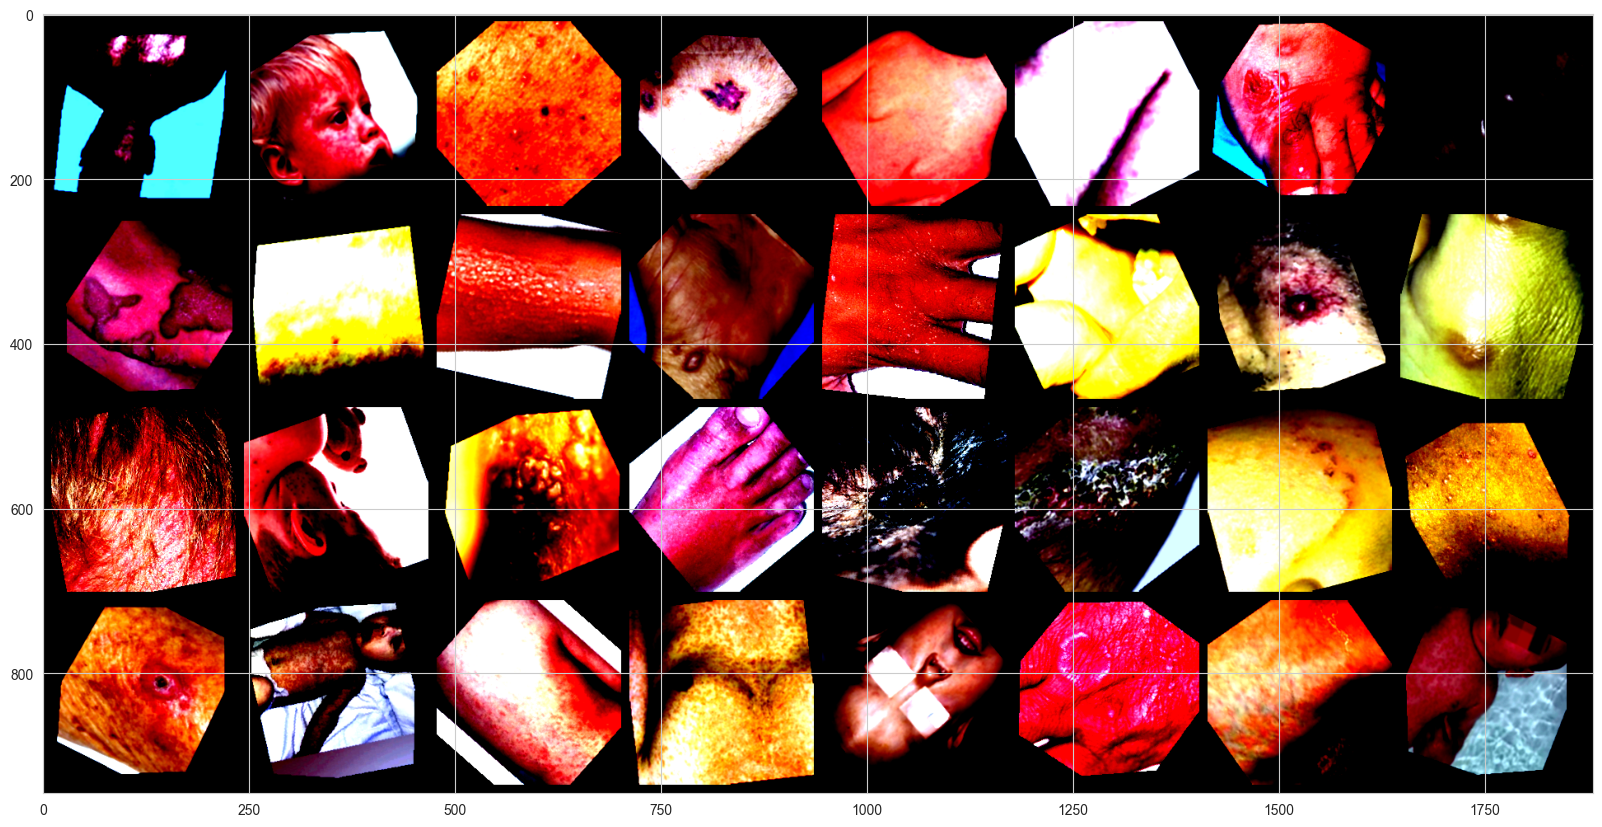

In [7]:
# construct a dummy train_loader to see some samples after transformation
train_loader_demo = DataLoader(train_set, batch_size=32, shuffle=True, num_workers=0, pin_memory=True)

images, targets = next(iter(train_loader_demo))
grid_images = make_grid(images, nrow=8, padding=10)
np_images = np.array(grid_images).transpose((1, 2, 0))
plt.figure(figsize=(20, 20))
plt.imshow(np_images)

In [7]:
targets

tensor([0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
        0, 0, 0, 0, 0, 0, 0, 0])

In [8]:
train_set

Dataset DatasetFolder
    Number of datapoints: 14229
    Root location: Measles2/training
    StandardTransform
Transform: Compose(
               RandomZoomOut(p=0.5, fill=0, side_range=(1, 1.2))
               RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
               RandomRotation(degrees=[-360.0, 360.0], interpolation=nearest, expand=False, fill=0)
               RandomHorizontalFlip(p=0.5)
               RandomVerticalFlip(p=0.5)
               ColorJitter(brightness=(0.8, 1.2), contrast=(0.8, 1.2), saturation=(0.8, 1.2), hue=(-0.1, 0.1))
               RandomPerspective(p=0.5, distortion_scale=0.2, interpolation=InterpolationMode.BILINEAR, fill=0)
               GaussianBlur(kernel_size=(3, 3), sigma=[0.1, 2.0])
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

## Model
The basic model here is simply a stack of convolutional layers followed by some fully-connected layers.

Since there are three channels for a color image (RGB), the input channels of the network must be three. In each convolutional layer, typically the channels of inputs grow, while the height and width shrink (or remain unchanged, according to some hyperparameters like stride and padding).

Before fed into fully-connected layers, the feature map must be flattened into a single one-dimensional vector (for each image). These features are then transformed by the fully-connected layers, and finally, we obtain the "logits" for each class.

WARNING -- You Must Know
You are free to modify the model architecture here for further improvement. However, if you want to use some well-known architectures such as ResNet50, please make sure NOT to load the pre-trained weights. Using such pre-trained models is considered cheating and therefore you will be punished. Similarly, it is your responsibility to make sure no pre-trained weights are used if you use torch.hub to load any modules.

For example, if you use ResNet-18 as your model:

model = torchvision.models.resnet18(pretrained=False) → This is fine.

model = torchvision.models.resnet18(pretrained=True) → This is NOT allowed.

In [8]:
pre_model=mobilenet_v3_large(weights=True)
#Modify the classifier section for 11 classes
num_classes =2



# Modify the classifier section to add a dropout layer for regularization
dropout = nn.Dropout(p=0.2, inplace=True)  # You can adjust the dropout probability as needed

modified_classifier = nn.Sequential(
    pre_model.classifier[0],pre_model.classifier[1],dropout,
    nn.Linear(1280, num_classes,bias=True),  # The Linear layer
)

# Replace the classifier in the model with the modified version
pre_model.classifier = modified_classifier


# Your Classifier class can remain the same:
class Classifier(nn.Module):
    def __init__(self,):
        super(Classifier, self).__init__()
        self.net = pre_model

    def forward(self, x):
        return self.net(x)

D:\Program Files\Python\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Large_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Large_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [9]:
pre_model

MobileNetV3(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): Conv2dNormActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
        )
      )
    )
    (2): InvertedResidual(
      (block): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 64, kernel_size=(1, 1), stride=(1, 1), bi

## Training
*   You can finish supervised learning by simply running the provided code without any modification.
*   The function "get_pseudo_labels" is used for semi-supervised learning. It is expected to get better performance if you use unlabeled data for semi-supervised learning. However, you have to implement the function on your own and need to adjust several hyperparameters manually.


In [9]:
import torch, gc
# "cuda" only when GPUs are available.
#class 00 and 01 have 496 and 5732 samples
#class_weights = [1/496,1/9870]
device = "cuda" if torch.cuda.is_available() else "cpu"



In [10]:
device

'cuda'

In [11]:
# Initialize a model, and put it on the device specified.
model = Classifier().to(device)
model.device = device

Training

  0%|          | 0/440 [00:00<?, ?it/s]

第1个epoch的学习率：0.000300
[ Train | 001/090 ] loss = 0.01368


  0%|          | 0/38 [00:00<?, ?it/s]

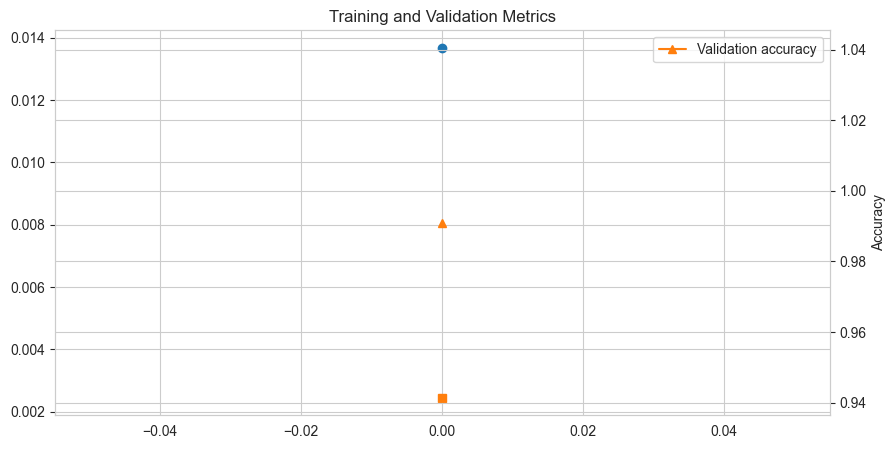

[ Valid | 001/090 ] loss = 0.00244, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第2个epoch的学习率：0.000297
[ Train | 002/090 ] loss = 0.01374


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 002/090 ] loss = 0.00220, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第3个epoch的学习率：0.000287
[ Train | 003/090 ] loss = 0.01341


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 003/090 ] loss = 0.00332, acc = 0.98602


  0%|          | 0/440 [00:00<?, ?it/s]

第4个epoch的学习率：0.000272
[ Train | 004/090 ] loss = 0.01346


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 004/090 ] loss = 0.00218, acc = 0.98766


  0%|          | 0/440 [00:00<?, ?it/s]

第5个epoch的学习率：0.000252
[ Train | 005/090 ] loss = 0.01305


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 005/090 ] loss = 0.00197, acc = 0.98931


  0%|          | 0/440 [00:00<?, ?it/s]

第6个epoch的学习率：0.000227
[ Train | 006/090 ] loss = 0.01272


  0%|          | 0/38 [00:00<?, ?it/s]

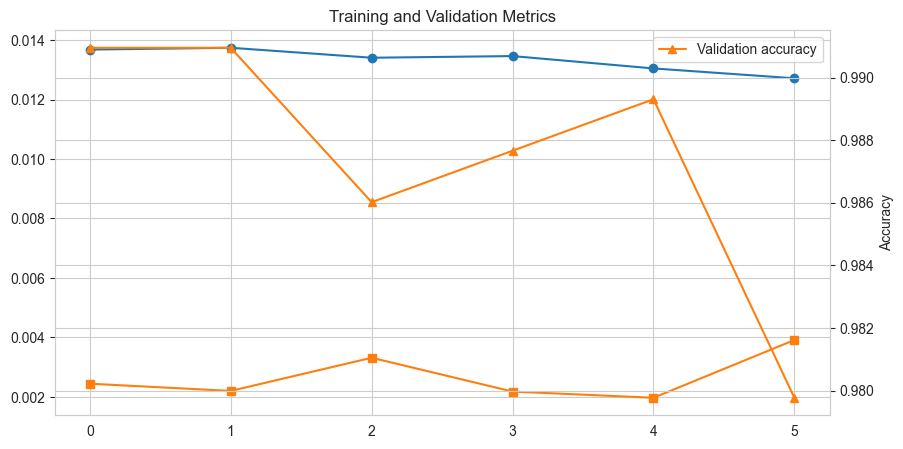

[ Valid | 006/090 ] loss = 0.00391, acc = 0.97977


  0%|          | 0/440 [00:00<?, ?it/s]

第7个epoch的学习率：0.000200
[ Train | 007/090 ] loss = 0.01245


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 007/090 ] loss = 0.00260, acc = 0.99128


  0%|          | 0/440 [00:00<?, ?it/s]

第8个epoch的学习率：0.000170
[ Train | 008/090 ] loss = 0.01262


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 008/090 ] loss = 0.00209, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第9个epoch的学习率：0.000140
[ Train | 009/090 ] loss = 0.01275


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 009/090 ] loss = 0.00380, acc = 0.98931


  0%|          | 0/440 [00:00<?, ?it/s]

第10个epoch的学习率：0.000110
[ Train | 010/090 ] loss = 0.01237


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 010/090 ] loss = 0.00248, acc = 0.99013


  0%|          | 0/440 [00:00<?, ?it/s]

第11个epoch的学习率：0.000083
[ Train | 011/090 ] loss = 0.01215


  0%|          | 0/38 [00:00<?, ?it/s]

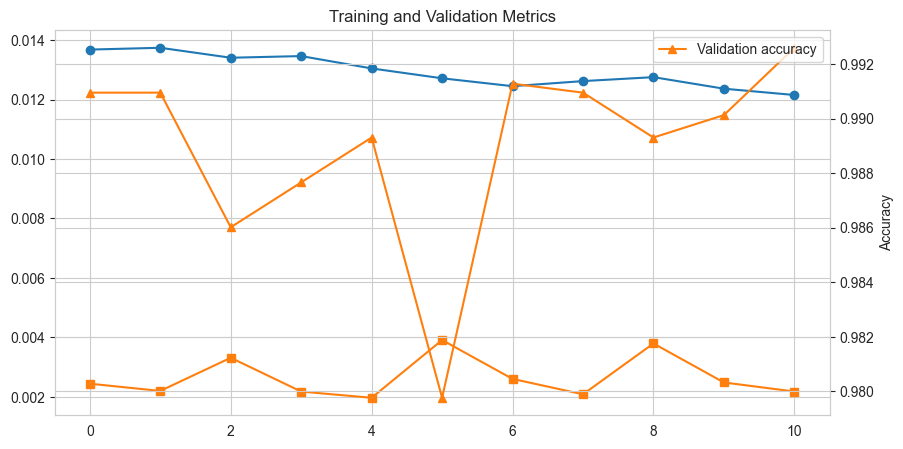

[ Valid | 011/090 ] loss = 0.00218, acc = 0.99260


  0%|          | 0/440 [00:00<?, ?it/s]

第12个epoch的学习率：0.000058
[ Train | 012/090 ] loss = 0.01219


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 012/090 ] loss = 0.00201, acc = 0.99260


  0%|          | 0/440 [00:00<?, ?it/s]

第13个epoch的学习率：0.000038
[ Train | 013/090 ] loss = 0.01180


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 013/090 ] loss = 0.00220, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第14个epoch的学习率：0.000023
[ Train | 014/090 ] loss = 0.01201


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 014/090 ] loss = 0.00218, acc = 0.99178


  0%|          | 0/440 [00:00<?, ?it/s]

第15个epoch的学习率：0.000013
[ Train | 015/090 ] loss = 0.01188


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 015/090 ] loss = 0.00200, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第16个epoch的学习率：0.000300
[ Train | 016/090 ] loss = 0.01317


  0%|          | 0/38 [00:00<?, ?it/s]

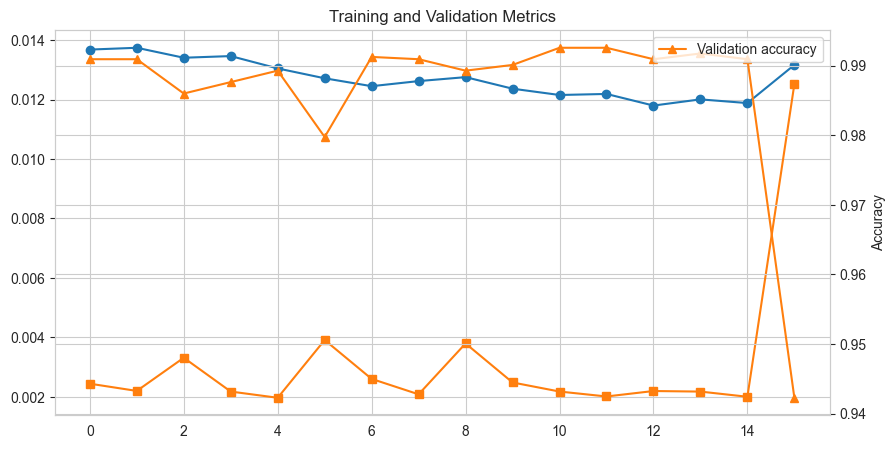

[ Valid | 016/090 ] loss = 0.01252, acc = 0.94227


  0%|          | 0/440 [00:00<?, ?it/s]

第17个epoch的学习率：0.000297
[ Train | 017/090 ] loss = 0.01360


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 017/090 ] loss = 0.00231, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第18个epoch的学习率：0.000287
[ Train | 018/090 ] loss = 0.01363


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 018/090 ] loss = 0.00241, acc = 0.98964


  0%|          | 0/440 [00:00<?, ?it/s]

第19个epoch的学习率：0.000272
[ Train | 019/090 ] loss = 0.01289


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 019/090 ] loss = 0.00251, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第20个epoch的学习率：0.000252
[ Train | 020/090 ] loss = 0.01271


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 020/090 ] loss = 0.00208, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第21个epoch的学习率：0.000227
[ Train | 021/090 ] loss = 0.01287


  0%|          | 0/38 [00:00<?, ?it/s]

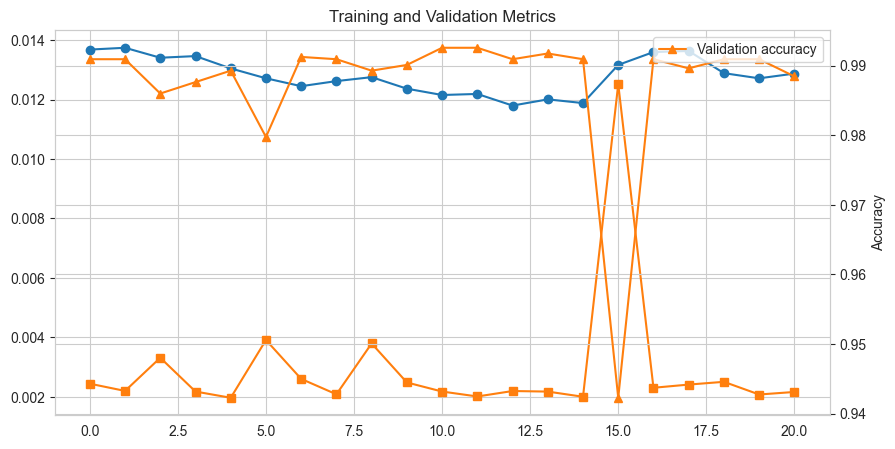

[ Valid | 021/090 ] loss = 0.00217, acc = 0.98849


  0%|          | 0/440 [00:00<?, ?it/s]

第22个epoch的学习率：0.000200
[ Train | 022/090 ] loss = 0.01272


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 022/090 ] loss = 0.00262, acc = 0.98766


  0%|          | 0/440 [00:00<?, ?it/s]

第23个epoch的学习率：0.000170
[ Train | 023/090 ] loss = 0.01241


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 023/090 ] loss = 0.00123, acc = 0.99589


  0%|          | 0/440 [00:00<?, ?it/s]

第24个epoch的学习率：0.000140
[ Train | 024/090 ] loss = 0.01221


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 024/090 ] loss = 0.00120, acc = 0.99671


  0%|          | 0/440 [00:00<?, ?it/s]

第25个epoch的学习率：0.000110
[ Train | 025/090 ] loss = 0.01211


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 025/090 ] loss = 0.00153, acc = 0.99507


  0%|          | 0/440 [00:00<?, ?it/s]

第26个epoch的学习率：0.000083
[ Train | 026/090 ] loss = 0.01210


  0%|          | 0/38 [00:00<?, ?it/s]

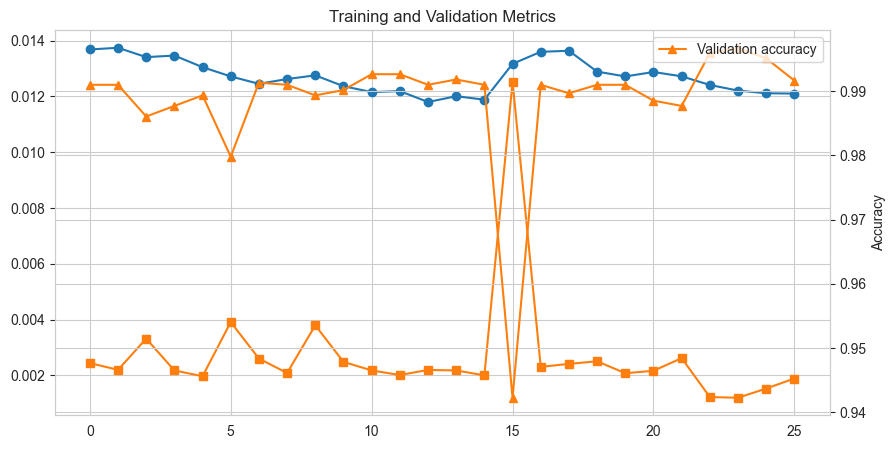

[ Valid | 026/090 ] loss = 0.00189, acc = 0.99161


  0%|          | 0/440 [00:00<?, ?it/s]

第27个epoch的学习率：0.000058
[ Train | 027/090 ] loss = 0.01213


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 027/090 ] loss = 0.00206, acc = 0.99342


  0%|          | 0/440 [00:00<?, ?it/s]

第28个epoch的学习率：0.000038
[ Train | 028/090 ] loss = 0.01181


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 028/090 ] loss = 0.00153, acc = 0.99424


  0%|          | 0/440 [00:00<?, ?it/s]

第29个epoch的学习率：0.000023
[ Train | 029/090 ] loss = 0.01174


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 029/090 ] loss = 0.00179, acc = 0.99260


  0%|          | 0/440 [00:00<?, ?it/s]

第30个epoch的学习率：0.000013
[ Train | 030/090 ] loss = 0.01178


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 030/090 ] loss = 0.00155, acc = 0.99342


  0%|          | 0/440 [00:00<?, ?it/s]

第31个epoch的学习率：0.000300
[ Train | 031/090 ] loss = 0.01338


  0%|          | 0/38 [00:00<?, ?it/s]

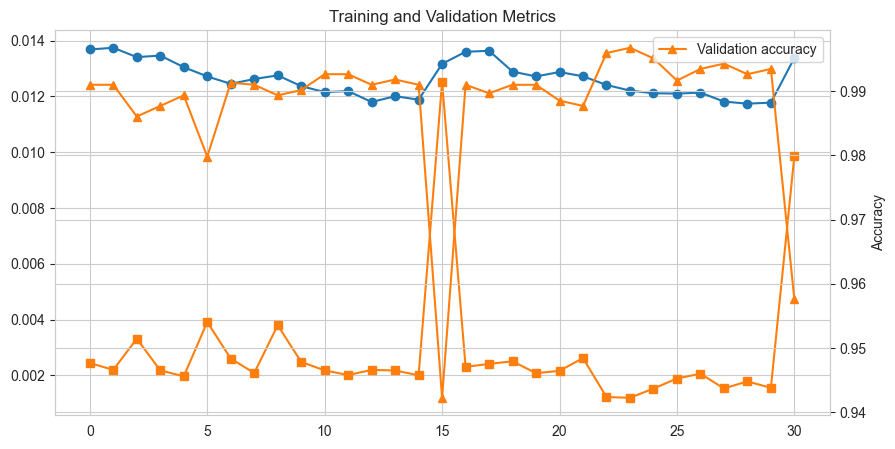

[ Valid | 031/090 ] loss = 0.00987, acc = 0.95757


  0%|          | 0/440 [00:00<?, ?it/s]

第32个epoch的学习率：0.000297
[ Train | 032/090 ] loss = 0.01278


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 032/090 ] loss = 0.00271, acc = 0.98503


  0%|          | 0/440 [00:00<?, ?it/s]

第33个epoch的学习率：0.000287
[ Train | 033/090 ] loss = 0.01282


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 033/090 ] loss = 0.00280, acc = 0.99013


  0%|          | 0/440 [00:00<?, ?it/s]

第34个epoch的学习率：0.000272
[ Train | 034/090 ] loss = 0.01284


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 034/090 ] loss = 0.00269, acc = 0.99260


  0%|          | 0/440 [00:00<?, ?it/s]

第35个epoch的学习率：0.000252
[ Train | 035/090 ] loss = 0.01272


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 035/090 ] loss = 0.00268, acc = 0.98635


  0%|          | 0/440 [00:00<?, ?it/s]

第36个epoch的学习率：0.000227
[ Train | 036/090 ] loss = 0.01246


  0%|          | 0/38 [00:00<?, ?it/s]

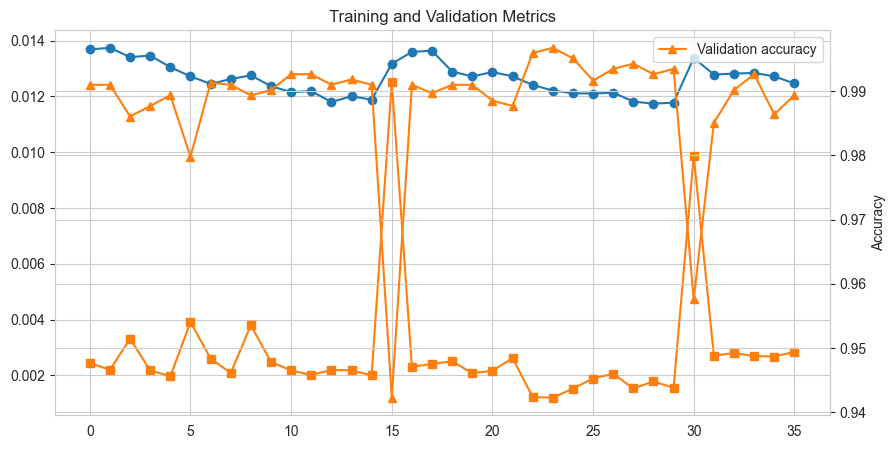

[ Valid | 036/090 ] loss = 0.00284, acc = 0.98931


  0%|          | 0/440 [00:00<?, ?it/s]

第37个epoch的学习率：0.000200
[ Train | 037/090 ] loss = 0.01225


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 037/090 ] loss = 0.00189, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第38个epoch的学习率：0.000170
[ Train | 038/090 ] loss = 0.01205


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 038/090 ] loss = 0.00312, acc = 0.98931


  0%|          | 0/440 [00:00<?, ?it/s]

第39个epoch的学习率：0.000140
[ Train | 039/090 ] loss = 0.01217


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 039/090 ] loss = 0.00238, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第40个epoch的学习率：0.000110
[ Train | 040/090 ] loss = 0.01224


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 040/090 ] loss = 0.00288, acc = 0.98931


  0%|          | 0/440 [00:00<?, ?it/s]

第41个epoch的学习率：0.000083
[ Train | 041/090 ] loss = 0.01187


  0%|          | 0/38 [00:00<?, ?it/s]

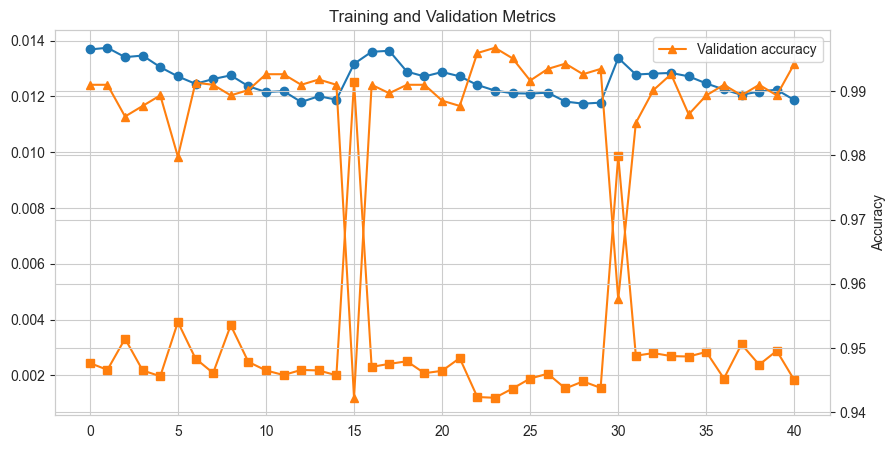

[ Valid | 041/090 ] loss = 0.00183, acc = 0.99424


  0%|          | 0/440 [00:00<?, ?it/s]

第42个epoch的学习率：0.000058
[ Train | 042/090 ] loss = 0.01182


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 042/090 ] loss = 0.00174, acc = 0.99342


  0%|          | 0/440 [00:00<?, ?it/s]

第43个epoch的学习率：0.000038
[ Train | 043/090 ] loss = 0.01183


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 043/090 ] loss = 0.00173, acc = 0.99424


  0%|          | 0/440 [00:00<?, ?it/s]

第44个epoch的学习率：0.000023
[ Train | 044/090 ] loss = 0.01166


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 044/090 ] loss = 0.00213, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第45个epoch的学习率：0.000013
[ Train | 045/090 ] loss = 0.01158


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 045/090 ] loss = 0.00262, acc = 0.99243


  0%|          | 0/440 [00:00<?, ?it/s]

第46个epoch的学习率：0.000300
[ Train | 046/090 ] loss = 0.01315


  0%|          | 0/38 [00:00<?, ?it/s]

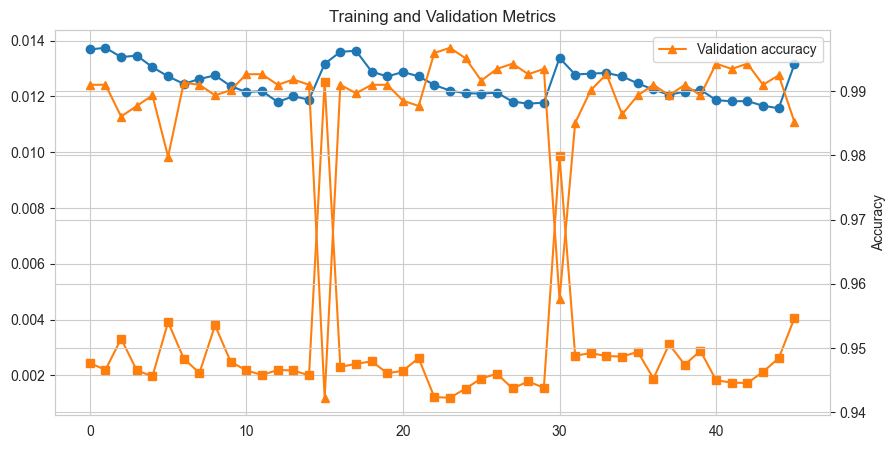

[ Valid | 046/090 ] loss = 0.00405, acc = 0.98520


  0%|          | 0/440 [00:00<?, ?it/s]

第47个epoch的学习率：0.000297
[ Train | 047/090 ] loss = 0.01273


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 047/090 ] loss = 0.00200, acc = 0.99260


  0%|          | 0/440 [00:00<?, ?it/s]

第48个epoch的学习率：0.000287
[ Train | 048/090 ] loss = 0.01304


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 048/090 ] loss = 0.00332, acc = 0.98964


  0%|          | 0/440 [00:00<?, ?it/s]

第49个epoch的学习率：0.000272
[ Train | 049/090 ] loss = 0.01250


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 049/090 ] loss = 0.00229, acc = 0.99424


  0%|          | 0/440 [00:00<?, ?it/s]

第50个epoch的学习率：0.000252
[ Train | 050/090 ] loss = 0.01192


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 050/090 ] loss = 0.00239, acc = 0.98849


  0%|          | 0/440 [00:00<?, ?it/s]

第51个epoch的学习率：0.000227
[ Train | 051/090 ] loss = 0.01227


  0%|          | 0/38 [00:00<?, ?it/s]

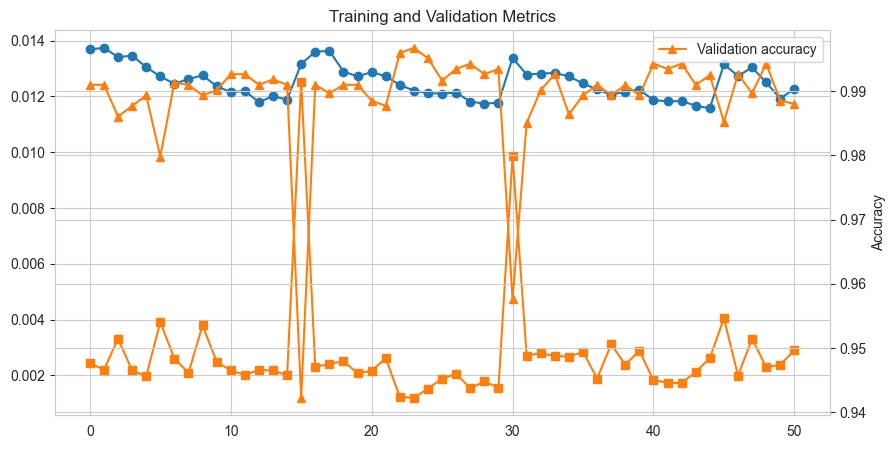

[ Valid | 051/090 ] loss = 0.00289, acc = 0.98799


  0%|          | 0/440 [00:00<?, ?it/s]

第52个epoch的学习率：0.000200
[ Train | 052/090 ] loss = 0.01224


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 052/090 ] loss = 0.00216, acc = 0.98849


  0%|          | 0/440 [00:00<?, ?it/s]

第53个epoch的学习率：0.000170
[ Train | 053/090 ] loss = 0.01179


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 053/090 ] loss = 0.00259, acc = 0.99095


  0%|          | 0/440 [00:00<?, ?it/s]

第54个epoch的学习率：0.000140
[ Train | 054/090 ] loss = 0.01199


  0%|          | 0/38 [00:00<?, ?it/s]

[ Valid | 054/090 ] loss = 0.00209, acc = 0.99128
Early stopping triggered. No improvement for 30 consecutive epochs.


In [13]:

# For the classification task, we use cross-entropy as the measurement of performance.
loss_fn = FocalLoss()

# Initialize optimizer, you may fine-tune some hyperparameters such as learning rate on your own.
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0003, weight_decay=0.001)
#scheduler
scheduler=torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer,eta_min=1e-5,T_0=15)
# The number of training epochs.
n_epochs = 90

# Whether to do semi-supervised learning.
do_semi = False

epoch_plot = []
train_loss_plot=[]
valid_loss_plot=[]
valid_acc_plot=[]
best_valid_loss = float('inf')  # Initialize with a large value
early_stopping_patience = 30  # Number of consecutive epochs without improvement to tolerate
epochs_without_improvement = 0

for epoch in range(n_epochs):
    
    # ---------- Training ----------
    model.train()

    # These are used to record information in training.
    train_loss = []
    train_accs = []
    epoch_plot.append(epoch)
    # Iterate the training set by batches.
    for batch in tqdm(train_loader):
        #print(f"Shape of batch: {batch[0].shape}",f"Shape of labels: {batch[1].shape}")
        # A batch consists of image data and corresponding labels.
        imgs, labels = batch
        #print(f"Shape of labels: {labels.shape}")
        # Forward the data. (Make sure data and model are on the same device.)
        logits = model(imgs.to(device))
        #print(f"Shape of logits: {logits.shape}")
        # Calculate the cross-entropy loss.
        # We don't need to apply softmax before computing cross-entropy as it is done automatically.
        #add regularization
        loss = loss_fn(logits, labels.to(device))
        #print(f"Shape of loss: {loss.shape}")
        # Gradients stored in the parameters in the previous step should be cleared out first.
        optimizer.zero_grad()

        # Compute the gradients for parameters.
        loss.backward()

        # Clip the gradient norms for stable training.
        grad_norm = nn.utils.clip_grad_norm_(model.parameters(), max_norm=10)

        # Update the parameters with computed gradients.
        optimizer.step()
        # Update the learning rate at the end of the epoch
        
        # Compute the accuracy for current batch.
        #acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        #acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()
        # Record the loss and accuracy.
        train_loss.append(loss.item())
        #train_accs.append(acc)
    print("第%d个epoch的学习率：%f" % (epoch+1,optimizer.param_groups[0]['lr']))
    scheduler.step()  # Adjust the learning rate
    # The average loss and accuracy of the training set is the average of the recorded values.
    train_loss = sum(train_loss) / len(train_loss)
    #train_acc = sum(train_accs) / len(train_accs)

    # Print the information.
    #print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}, acc = {train_acc:.5f}")
    print(f"[ Train | {epoch + 1:03d}/{n_epochs:03d} ] loss = {train_loss:.5f}")
    
    # ---------- Validation ----------
    # Make sure the model is in eval mode so that some modules like dropout are disabled and work normally.
    model.eval()

    # These are used to record information in validation.
    valid_loss = []
    valid_accs = []

    # Iterate the validation set by batches.
    for batch in tqdm(valid_loader):

        # A batch consists of image data and corresponding labels.
        imgs, labels = batch

        # We don't need gradient in validation.
        # Using torch.no_grad() accelerates the forward process.
        with torch.no_grad():
          logits = model(imgs.to(device))

        # We can still compute the loss (but not the gradient).
        #logits and labels are not in the same size, we need to convert labels from (batch) to (32,2) shape
        loss_labels= torch.nn.functional.one_hot(labels, num_classes=2).float()
        loss = loss_fn(logits, loss_labels.to(device))

        # Compute the accuracy for current batch.
        acc = (logits.argmax(dim=-1) == labels.to(device)).float().mean()

        # Record the loss and accuracy.
        valid_loss.append(loss.item())
        valid_accs.append(acc)

    # The average loss and accuracy for entire validation set is the average of the recorded values.
    valid_loss = sum(valid_loss) / len(valid_loss)
    valid_acc = sum(valid_accs) / len(valid_accs)
    #draw the picture
    train_loss_plot.append(train_loss)
    valid_loss_plot.append(valid_loss)
    valid_acc_plot.append(valid_acc.cpu())
    if epoch%5==0:
        plt.figure(figsize=(10, 5))
        plt.plot(epoch_plot, train_loss_plot, label='Training loss', marker='o')
        plt.plot(epoch_plot, valid_loss_plot, label='Validation loss', marker='s')

        # Create a twin Axes for the second y-axis
        ax2 = plt.twinx()

        # Plot train and validation accuracy on the second y-axis
        ax2.plot(epoch_plot, valid_acc_plot, label='Validation accuracy', color='tab:orange', marker='^')
        #ax2.plot(epoch_plot, train_acc_plot, label='Training accuracy', color='tab:green', marker='x')
        # Label the y-axes
        plt.ylabel('Loss')
        ax2.set_ylabel('Accuracy')

        # Show legends for both y-axes
        plt.legend(loc='upper left')
        ax2.legend(loc='upper right')

        # Set labels and title
        plt.xlabel('Epoch')
        plt.title('Training and Validation Metrics')

        # Display the plot
        plt.show()
      
    # Print the information.0
    print(f"[ Valid | {epoch + 1:03d}/{n_epochs:03d} ] loss = {valid_loss:.5f}, acc = {valid_acc:.5f}")
    #early stopping
    # Check if the validation loss has improved
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        epochs_without_improvement = 0
        torch.save(model.state_dict(),'teacher1.ckpt')
    else:
        epochs_without_improvement += 1
    
    # Check if early stopping criteria are met
    if epochs_without_improvement >= early_stopping_patience:
        print("Early stopping triggered. No improvement for", early_stopping_patience, "consecutive epochs.")
        break  # Exit the training loop    
